In [ ]:
from transformers import AutoModel, AutoImageProcessor
import torch
from datasets import load_dataset

dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]

processor = AutoImageProcessor.from_pretrained(
    "yukiharada1228/abn-resnet18-imagenette",
    trust_remote_code=True,
)
model = AutoModel.from_pretrained(
    "yukiharada1228/abn-resnet18-imagenette",
    trust_remote_code=True,
)

inputs = processor(images=image, return_tensors="pt")

# 推論
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs["per_logits"]  # 予測用のlogits
    attention_map = outputs["att_map"]  # アテンションマップ (B,1,H,W)

# モデルは1000クラスのImageNetいずれかを予測します
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

/data1/yukiharada/attention-branch-network/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You passed `num_labels=10` which is incompatible to the `id2label` map of length `1000`.


tabby, tabby cat


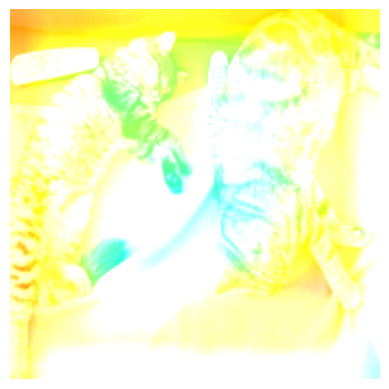

In [3]:
# アテンションマップの可視化
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 画像の前処理（BGR形式に変換）
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
img_tensor = inputs["pixel_values"][0]
img_rgb = img_tensor.cpu().numpy().transpose((1, 2, 0))
img_rgb = (img_rgb * np.array(std) + np.array(mean)) * 255.0  # 正規化を元の画像スケール(RGB,0-255)に戻す
img_rgb = np.clip(img_rgb, 0, 255).astype(np.uint8)
img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

# アテンションマップを画像サイズにリサイズ
att_map = attention_map[0, 0].cpu().numpy()  # (H, W)
h, w = img_bgr.shape[:2]
att_resized = cv2.resize(att_map, (w, h))

# ヒートマップを生成
att_scaled = (att_resized * 255.0).astype(np.uint8)
jet_map = cv2.applyColorMap(att_scaled, cv2.COLORMAP_JET)

# アテンションヒートマップを原画像に重ね合わせ
overlay = cv2.add(img_bgr, jet_map)

# 可視化
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()